### Installing necessary libraries that are not pre-installed in Google Colab

In [5]:
!pip install datasets
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [6]:
!pip install --upgrade transformers
!pip install --upgrade datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 36.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


### Importing necessary libraries

In [7]:
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict

import tensorflow as tf
from transformers import DataCollatorWithPadding, create_optimizer, AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
from transformers.keras_callbacks import KerasMetricCallback
import evaluate

Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining the path to the working directory

In [9]:
PATH_TO_DRIVE = '/content/drive/MyDrive/text_project/'

## Training

### Loading the dataset

Loading dataset to a pandas dataframe

In [10]:
df = pd.read_json(PATH_TO_DRIVE + 'News_Category_Dataset_v3.json', lines = True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


### Exploring the dataset

Checking for missing values

In [ ]:
# Check for missing values
missing_values = df.isnull()

# Get the indices of missing values
missing_indices = missing_values[missing_values.any(axis=1)].index

print("Indices of missing values:")
print(missing_indices.values)

Indices of missing values:
[]


Printing the unique categories

In [ ]:
df["category"].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

Merge the categories "WORLDPOST" and "THE WORLDPOST" to one

In [ ]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

So, now we have these 41 categories

In [ ]:
df["category"].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'WORLDPOST', 'GOOD NEWS', 'FIFTY', 'ARTS',
       'DIVORCE'], dtype=object)

In [ ]:
len(df["category"].unique())

41

Let's see the distribution of the categories in the dataset

Text(0, 0.5, 'Categories')

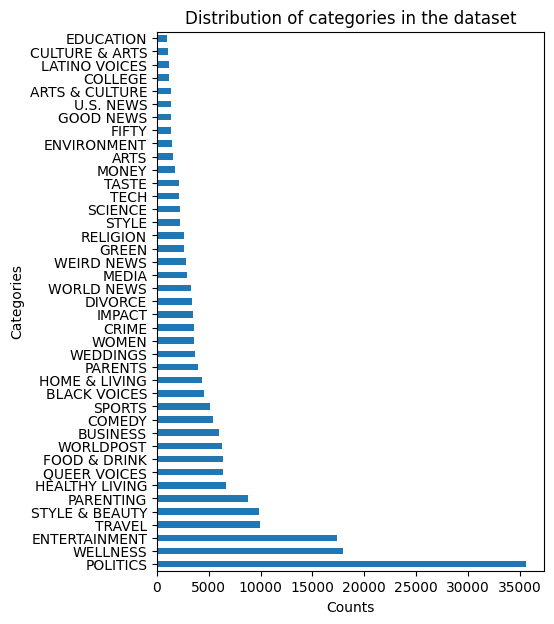

In [ ]:
df['category'].value_counts().plot(kind='barh', title='Distribution of categories in the dataset', figsize=(5,7))
plt.xlabel("Counts")
plt.ylabel("Categories")

In [ ]:
category_counts = df['category'].value_counts()
print(category_counts)

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
WORLDPOST          6243
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION          1014
Name: c

*As we can see there is an imbalance in the dataset with the "POLITICS" being the category with the most observations and the "EDUCATION" with the least.*

Calculating the length of headlines and short descriptions

In [ ]:
#calculating the length of headlines and descriptions
df['descr_len'] = df['short_description'].apply(lambda x: len(str(x).split()))
df['headline_len'] = df['headline'].apply(lambda x: len(str(x).split()))

Let's see the distribution of the length of headlines and short descriptions

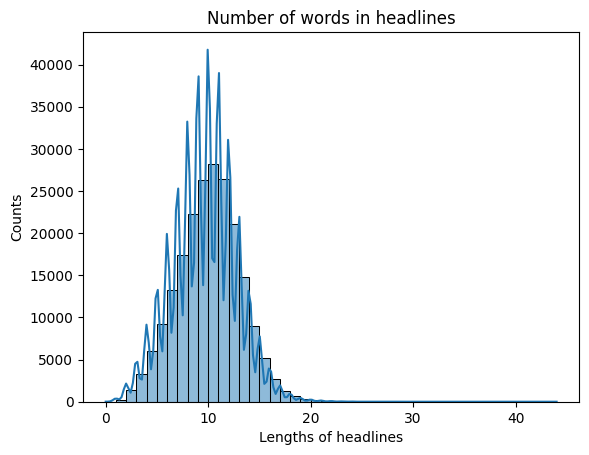

In [ ]:
sns.histplot(df['headline_len'], kde=True, binwidth=1)
plt.title('Number of words in headlines')
plt.xlabel("Lengths of headlines")
plt.ylabel("Counts")
plt.show()

*As we can see from the plot above, the majority of the observations have a headline of length 10 and all the observations have at least 1 word in the headline*

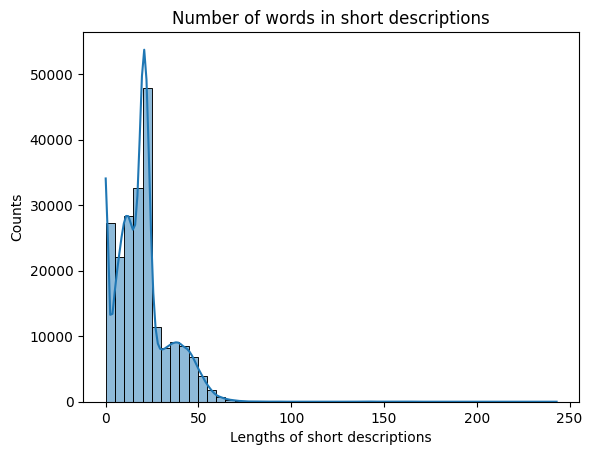

In [ ]:
sns.histplot(df['descr_len'], kde=True, binwidth=5)
plt.title('Number of words in short descriptions')
plt.xlabel("Lengths of short descriptions")
plt.ylabel("Counts")
plt.show()

*As we can see from the plot above, the majority of the observations have a content of approximately 20-25 words.*

In [ ]:
df.describe()

,date,descr_len,headline_len
count,209527,209527.000000,209527.000000
mean,2015-04-30 00:44:14.344308736,19.669026,9.600744
min,2012-01-28 00:00:00,0.000000,0.000000
25%,2013-08-10 00:00:00,10.000000,8.000000
50%,2015-03-16 00:00:00,19.000000,10.000000
75%,2016-11-01 00:00:00,24.000000,12.000000
max,2022-09-23 00:00:00,243.000000,44.000000
std,NaN,14.152783,3.068507


*We can see from the table above that there exists data where the length of their short description is 0, while the average length is 20. Similarly, there is data where the length of the headline is 0. These datapoints are likely problematic, so we print the elements with length of title equal to zero and after that, the elements with length of short description less than 5 for further investigation.*

In [ ]:
descr_result = df[df['descr_len'] < 5]
pd.set_option('max_colwidth', None)
descr_result[["short_description", "headline", "link"]]

,short_description,headline,link
155,Who's nasty??,Jared Kushner Blasts 'Nasty Troll' Chrissy Teigen For Attacks On Ivanka,https://www.huffpost.com/entry/jared-kushner-chrissy-teigen-nasty-troll-ivanka-trump_n_630958dfe4b088f742346aa3
238,"So long, social distancing.","CDC Drops Some Quarantine, Screening Recommendations For COVID-19",https://www.huffpost.com/entry/cdc-covid-19-quarantine-social-distancing-rules_n_62f55ed7e4b0526eaee8fe8c
478,There are 50.,Herschel Walker Says There Are 52 States,https://www.huffpost.com/entry/herschel-walker-52-states_n_62b35b92e4b0cf43c85f2cd4
953,"Introducing… “Cruz Missile PR.""",'Daily Show' Torches Ted Cruz With A New Job He'd Be Brilliant At,https://www.huffpost.com/entry/ted-cruz-daily-show-reverse-oprah_n_623ef104e4b0e340f6a37d77
1183,This could be big.,Rudy Giuliani Reportedly In Talks To Testify Before Jan. 6 Committee,https://www.huffpost.com/entry/rudy-giuliani-talks-testify-jan-6-house-committee_n_6208b4c2e4b03230246bac88
...,...,...,...
206924,,True LGBTQ Stories: When A College Football Team Defended Its Gay Captain (VIDEO),https://www.huffingtonpost.com/entry/true-lgbtq-stories_us_5bafa0b4e4b0ad76925f1214
206939,,'Chasing Ice' -- The Climate Change Debate Is Over,https://www.huffingtonpost.com/entry/chasing-ice-climate-change_us_5bb10d1fe4b09bbe9a59c366
208803,,Practice for International Kissing Day: 'Love Is Love',https://www.huffingtonpost.com/entry/love-is-love_us_5bb18e6ae4b01857b707dc81
208865,,"Zach Huston, Victim of Brutal Ohio School Bullying, Tells His Story (VIDEO)",https://www.huffingtonpost.com/entry/zach-huston-bullying_us_5baf9fa9e4b0ad76925efd83


*For the short descriptions with length less than 5 words, I randomly chose to visit some links and observed that they truly exist and their short descriptions are the one that the dataset has. So, I decide to keep these observations.*

In [ ]:
headline_result = df[df['headline_len'] == 0]
pd.set_option('max_colwidth', None)
headline_result[["short_description", "headline", "link"]]

,short_description,headline,link
90944,,,https://www.huffingtonpost.com/entry/lincoln-20_b_8023742.html
95567,"Let everyone not wrapped in tired and disproven doctrines about sex rid themselves of anti-scientific dogmas and be free. The law of grace, not of fear, can now blow freely.",,https://www.huffingtonpost.com/entry/post_9671_b_7683632.html
103675,,,https://www.huffingtonpost.com/entry/us-and-europes-economic-a_b_6962262.html
109100,,,https://www.huffingtonpost.com/entry/disney-ceo-iger-readies-m_b_6520290.html
110153,,,https://www.huffingtonpost.com/entry/beverly-hills-hotel-caugh_b_6414708.html
122145,,,https://www.huffingtonpost.com/entry/beverly-hills-hotel-boyco_b_5711931.html


*Now, for the headlines, there are 6 datapoints with length of the headline equal to zero. The links of these articles do not work properly, so we can assume that these observations are problematic and can be removed from the dataset.*

### Preprocessing the dataset

In [ ]:
df.drop(headline_result.index, inplace=True)
df = df.reset_index(drop = True)

Cased letters will not carry extra information, thus we plan to use an uncased pre-trained model. This means that we need to convert each of the news titles and content into lowercase.

In [ ]:
df['headline'] = df['headline'].apply(lambda headline: str(headline).lower())
df['short_description'] = df['short_description'].apply(lambda descr: str(descr).lower())

Going with the intuition that the headline is often more descriptive of the category of the news, as well as to provide more text data to the model, let's add the "headline" column to the "short_description" column and create a new column named "full_content". This new column will be the input for our model. We should also note the headline goes first, to avoid losing headline information during truncation.

In [ ]:
df['full_content'] = df['headline'] + " " + df['short_description']

Our labels are not in the proper format for our model and need to be encoded. After this each label would be mapped to an integer.

In [ ]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

We then save the encoder for reproducibility

In [ ]:
with open(PATH_TO_DRIVE + 'label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

Train - test split
20% of the data will be used to get a first accuracy estimate of the model and select the most suitable epoch for deployment

In [ ]:
X_train,X_test ,y_train,y_test = train_test_split(df['full_content'], df['categoryEncoded'], random_state = 2020, test_size = 0.2)

In [ ]:
dataset = Dataset.from_pandas(df[["full_content", "categoryEncoded"]])

tdf = pd.DataFrame({"text": X_train.tolist(), "label": y_train.tolist()})
vdf = pd.DataFrame({"text": X_test.tolist(), "label": y_test.tolist()})
tds = Dataset.from_pandas(tdf)
vds = Dataset.from_pandas(vdf)

ds = DatasetDict()

ds['train'] = tds
ds['validation'] = vds

print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 167616
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 41905
    })
})


Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", model_max_length=512)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

text_tokenized = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/167616 [00:00<?, ? examples/s]

Map:   0%|          | 0/41905 [00:00<?, ? examples/s]

So our tokenized dataset has the structure below

In [ ]:
text_tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 167616
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 41905
    })
})

### Model training

Defining the model

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=len(df["category"].unique()))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

I save the model so as to make it reproducible.

In [ ]:
model.save_pretrained(PATH_TO_DRIVE)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(PATH_TO_DRIVE)

Some layers from the model checkpoint at /content/drive/MyDrive/text_project/ were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/text_project/ and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  31529     
                                                                 
 dropout_79 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66985001 (255.53 MB)
Trainable params: 66985001 (255.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Defining the training parameters

In [ ]:
batch_size = 32
num_epochs = 5
batches_per_epoch = len(text_tokenized["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

Preparing the dataset

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    text_tokenized["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    text_tokenized["validation"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

Compiling the model

In [ ]:
model.compile(optimizer=optimizer)

Defining two callbacks. One for printing the accuracy in validation set after each epoch and one for saving the weights of the model

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= PATH_TO_DRIVE + 'model-{epoch:03d}.h5',
    verbose=1,
    save_weights_only=True,
    monitor='accuracy',
    save_best_only=True,
    mode='auto'
)

Training

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=num_epochs, callbacks=[metric_callback, checkpoint])

Epoch 1/5
5238/5238 [==============================] - ETA: 0s - loss: 1.3552
Epoch 1: accuracy improved from -inf to 0.68918, saving model to /content/drive/MyDrive/text_project/model-001.h5
5238/5238 [==============================] - 1805s 339ms/step - loss: 1.3552 - val_loss: 1.0651 - accuracy: 0.6892
Epoch 2/5
5238/5238 [==============================] - ETA: 0s - loss: 0.9159
Epoch 2: accuracy improved from 0.68918 to 0.70347, saving model to /content/drive/MyDrive/text_project/model-002.h5
5238/5238 [==============================] - 1700s 325ms/step - loss: 0.9159 - val_loss: 0.9960 - accuracy: 0.7035
Epoch 3/5
5238/5238 [==============================] - ETA: 0s - loss: 0.7263
Epoch 3: accuracy improved from 0.70347 to 0.70782, saving model to /content/drive/MyDrive/text_project/model-003.h5
5238/5238 [==============================] - 1697s 324ms/step - loss: 0.7263 - val_loss: 0.9975 - accuracy: 0.7078
Epoch 4/5
5238/5238 [==============================] - ETA: 0s - loss: 0.

#Testing

Loading the model with its weights, the tokenizer, the data collator and the label encoder

In [ ]:
# Load the model, the tokenizer and the data collator
model_new = TFAutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=len(df["category"].unique()))
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Load the saved weights into the model
saved_weights_path = PATH_TO_DRIVE + 'model-004.h5'  # specify the path to your saved weights
model_new.load_weights(saved_weights_path)

#Load the encoder
pkl_file = open(PATH_TO_DRIVE + 'label_encoder.pkl', 'rb')
encoder = pickle.load(pkl_file)
pkl_file.close()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### Testing in a simple example

In [ ]:
text = "Yesteday's drag show was a hit! They were reading stories for the kindergarden children, singing and dancing."

In [ ]:
input = text.lower()

# Get label
inputs = tokenizer(input, return_tensors="tf")
logits = model_new(**inputs).logits
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
label = encoder.classes_[predicted_class_id]
print("Predicted label: ", label)

# Get confidence
probabilities = tf.nn.softmax(logits)
conf = max(probabilities[0]).numpy()
print("Probability of predicted label: ", float(conf))

Predicted label:  QUEER VOICES
Probability of predicted label:  0.9539899230003357


### Testing in validation set

Predicting the labels

In [ ]:
pred = model_new.predict(tf_validation_set)
predicted_class_id_test = tf.math.argmax(pred.logits, axis=-1)
y_pred = predicted_class_id_test.numpy()

1310/1310 [==============================] - 140s 98ms/step


In [ ]:
y_true = y_test.to_numpy()

In [ ]:
unique_labels = set(ds['train']["label"])

In [ ]:
target_names = encoder.inverse_transform([i for i in range(len(unique_labels))])

Printing the metrics

In [ ]:
print(classification_report(y_true, y_pred, target_names=target_names))

                precision    recall  f1-score   support

          ARTS       0.52      0.53      0.52       308
ARTS & CULTURE       0.55      0.52      0.53       258
  BLACK VOICES       0.59      0.53      0.56       890
      BUSINESS       0.58      0.60      0.59      1189
       COLLEGE       0.48      0.55      0.51       232
        COMEDY       0.60      0.50      0.54      1059
         CRIME       0.66      0.64      0.65       734
CULTURE & ARTS       0.69      0.47      0.56       198
       DIVORCE       0.87      0.81      0.84       682
     EDUCATION       0.50      0.50      0.50       205
 ENTERTAINMENT       0.75      0.80      0.78      3520
   ENVIRONMENT       0.60      0.48      0.53       288
         FIFTY       0.59      0.48      0.53       311
  FOOD & DRINK       0.74      0.80      0.77      1258
     GOOD NEWS       0.45      0.39      0.42       264
         GREEN       0.49      0.56      0.52       524
HEALTHY LIVING       0.56      0.45      0.50  